In [1]:
%%capture
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
! pip install cvxpy
import cvxpy as cp
from tqdm import tqdm
import pandas as pd
import networkx as nx
from collections import Counter
from sklearn.preprocessing import StandardScaler
actual_path = os.getcwd()

In [2]:
def gaussian_ker(x, y, q):
    """a function to compute the gaussian kernel of two points
    -------------------------------
    inputs : 

    x : array-like, vector
    first vector for which we want to compute the kernel

    y : array-like, vector
    second vector for which we want to compute the kernel

    q : positive float,
    value of the bandwidth of the kernel

    returns:
    ker : float,
    the value of the kernel
    -------------------------------
    """

    ker = np.exp(-q*np.linalg.norm(x-y)**2)
    return ker

In [3]:
def gram_mat(X, q):
    """
    a function to compute the gram matrix of a given dataset

    ----------------------------------------
    inputs : 
    X : array-like object, must be 2D
    the data for which we want to compute the gram matrix

    q : positive float, 
    the bandwidth of the gaussian kernel
    -----------------------------------------

    returns:
    K : the gram matrix
    """
    
    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]
    K = np.exp(-squared_euclidian_distances*q)
    return K

In [4]:
def compute_seg(x, y, nb=20):
    """
    a function used to compute the segment between two points
    -----------------------------------
    Parameters : 

    x : array-like obj,
    an input, d>=2

    y : array-like obj, 
    the second input

    nb : int, 
    the number of points we want to have between the two points

    Returns : 

    segment : array-like
    an array of shape d (dimension of x), nb
    ---------------------------------------
    """
    d = x.shape[0]
    segment = np.zeros((nb, d))
    points = np.linspace(start=0., stop=1., num=nb, endpoint=True)
    
    for i in range(nb):
        t = points[i]
        segment[i, :] = (1-t) * x + t * y
        
    return segment

In [5]:
def radius(x, sample, beta, bkb, q, ker_self=1.):
    """
    compute the radius for a given instance x
    -----------------------------------------------
    Parameters : 

    x : 1-D vector,
    the input vector

    sample : matrix, 
    the whole sample, 

    beta : array-like, 
    the calculated beta

    bkb : float,
    the result of beta.T@K@beta

    ker_self : float,
    the value of the kernel of the selected instance with itself, 
    set to 1 by default as we use mostly the gaussian kernel

    returns :

    radius : float,
    the distance between the test instance and the center of the 
    sphere enclosing all the points in the Hilbert space
    -----------------------------------------------
    """
    nb_samp = sample.shape[0]
    temp_k = np.zeros(nb_samp)

    for elem in range(nb_samp):
        temp_k[elem] = gaussian_ker(x, sample[elem,:], q=q)
        
    return np.sqrt(ker_self - 2*np.dot(temp_k, beta) + bkb)

In [6]:
actual_path = os.getcwd()
os.chdir(f'{actual_path}/data')
original_data = pd.read_csv('OnlineNewsPopularity.csv')
os.chdir(actual_path)

full_names = []
for name in list(original_data.columns):
    temp_name = name.split()
    full_names.append(temp_name[0])

original_data.columns = full_names

original_data.columns

original_data.drop(['url','timedelta'],axis=1,inplace=True)

original_data['shares'].describe()
n = original_data.shape[0]


original_data['pop_cat'] = original_data['shares'].copy()
data = original_data.copy()
for i in range(n):
    if data.loc[i,'shares'] < 946.:
        data.loc[i,'pop_cat'] = 0
    elif data.loc[i,'shares'] < 1400. :
        data.loc[i,'pop_cat'] = 1
    elif data.loc[i,'shares'] < 2800. :
        data.loc[i,'pop_cat'] = 2
    elif data.loc[i,'shares'] >= 2800. :
        data.loc[i,'pop_cat'] = 3

#we created categories depending on the quartiles of the data in order to try
#to have a classification set up instead of a regression onne

In [7]:
target = data['pop_cat'].copy()

In [8]:
#we center the data for the pca (as done in the article)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('pop_cat', axis=1))


n_components = 7 
pca = PCA(n_components=n_components)

principal_components = pca.fit_transform(data_scaled)
columns = [f"PC{i+1}" for i in range(n_components)]
principal_df = pd.DataFrame(data=principal_components, columns=columns)


print("part of variance explained by every component :", pca.explained_variance_ratio_)


print("total variance explained :", np.sum(pca.explained_variance_ratio_))

d = principal_df.shape[1]
principal_df = np.hstack((principal_df,target.to_numpy().reshape(-1,1)))
principal_df_whole = principal_df.copy()
principal_df = pd.DataFrame(principal_df)

part of variance explained by every component : [0.08132705 0.06788542 0.06098941 0.05087395 0.04611231 0.04352561
 0.0411103 ]
total variance explained : 0.39182406118988544


In [9]:
#we rename the columns (more of a commidity than a necessity)
colnames = []
for i in range(7):
    colnames.append(f'pc_{i}')
colnames.append('target')
principal_df.columns = colnames
principal_df = principal_df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.01,random_state=87876899))
target = principal_df['target'].copy()
n = principal_df.shape[0]
#we subsample a lot because otherwise our code doesn't run

(397, 8)


/tmp/ipykernel_8370/1550396598.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  principal_df = principal_df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.01,random_state=87876899))


In [10]:
principal_df.drop('target',axis=1,inplace=True)

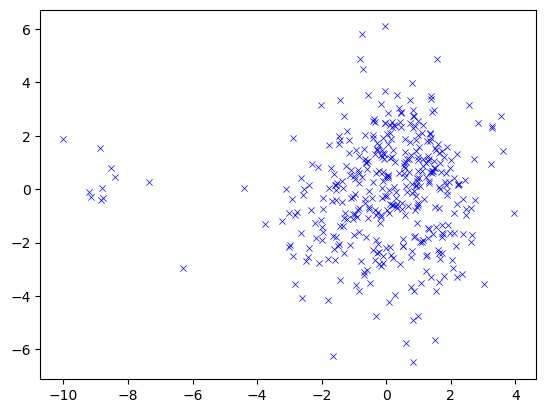

In [11]:
#a quick plot to see to what extent does the pca contributes to the possibility of 
#separation of the data (here on the first two components) 
plt.scatter(principal_df.iloc[:, 0], - principal_df.iloc[:, 1], marker='x', color='blue', s=20, linewidths=0.5)
plt.show()

In [12]:
# Hyperparameters of the SVC procedure
N = n
q = 0.01
p = 0.5
C = 1/(n*p)

In [13]:
gram_x = gram_mat(X=principal_df, q=q)

In [14]:
n = len(principal_df)
beta = cp.Variable(n)
gram_x += gram_x.T
gram_x /= 2
gram_x = cp.psd_wrap(gram_x)


objective = cp.Maximize(cp.sum(np.ones(n) @ beta) - cp.quad_form(beta, gram_x))


constraints = [
    beta >= 0,  # 0 <= beta_j
    beta <= C,  # beta_j <= C
    cp.sum(beta) == 1  # sum equal to 1
]


problem = cp.Problem(objective, constraints)


problem.solve(solver='CLARABEL')

np.float64(0.3703262571086876)

In [15]:
true_beta = beta.value
beta_k_beta = true_beta.T @ gram_x @ true_beta

In [16]:
index_of_sv = []
index_of_bsv = []
N = principal_df.shape[0]
for i in range(N):
    if 1e-10 < true_beta[i] and true_beta[i] < C:
        index_of_sv.append(i)
    elif true_beta[i] >= C - 1e-3:
        index_of_bsv.append(i)

print('index of sv', index_of_sv)
print('number of sv', len(index_of_sv))
print('index of bsv', index_of_bsv)
print('number of bsv', len(index_of_bsv))

index of sv [2, 4, 5, 6, 17, 20, 23, 29, 31, 34, 37, 42, 43, 44, 45, 47, 48, 50, 54, 55, 56, 60, 61, 63, 64, 65, 68, 70, 74, 75, 79, 81, 82, 85, 89, 90, 91, 99, 102, 105, 106, 107, 113, 118, 119, 121, 131, 134, 137, 138, 139, 143, 144, 149, 150, 154, 155, 156, 157, 160, 162, 164, 166, 167, 168, 169, 170, 171, 172, 175, 178, 179, 180, 183, 184, 185, 187, 189, 190, 194, 195, 197, 203, 204, 206, 209, 210, 212, 215, 216, 222, 223, 227, 230, 233, 235, 239, 243, 244, 245, 248, 250, 251, 252, 255, 256, 257, 261, 267, 268, 269, 270, 272, 274, 275, 276, 277, 283, 284, 285, 286, 288, 291, 292, 293, 295, 297, 298, 300, 301, 304, 305, 308, 313, 315, 319, 321, 323, 326, 328, 334, 335, 337, 346, 348, 351, 352, 353, 359, 360, 361, 362, 363, 366, 367, 368, 369, 371, 372, 373, 374, 375, 376, 377, 380, 382, 385, 386, 394, 395]
number of sv 170
index of bsv [1, 8, 12, 14, 15, 28, 39, 40, 49, 57, 58, 59, 62, 72, 86, 87, 96, 108, 111, 112, 116, 123, 124, 130, 133, 140, 141, 152, 158, 161, 188, 191, 218, 22

In [17]:
potential_sv = principal_df.iloc[index_of_sv, :].to_numpy()

In [18]:
gram_x = gram_mat(X=principal_df, q=q)
gram_x += gram_x.T
gram_x /= 2
r = []
beta_k_beta = true_beta.T @ gram_x @ true_beta
for point_sv in potential_sv:
    temp_K = np.zeros(N)
    for elem in range(N):
        temp_K[elem] = gaussian_ker(point_sv, principal_df.iloc[elem, :], q=q)
    r_xi = np.sqrt(1 - 2 * np.dot(temp_K, true_beta) + beta_k_beta)
    r.append(r_xi)
rad = np.mean(r)

In [19]:
n = principal_df.shape[0]
adjacency_mat = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i+1, n):
        decision = True
        segment = compute_seg(x=principal_df.to_numpy()[i,:], y=principal_df.to_numpy()[j,:])
        list_of_val = []
        for point in segment:
            dist = radius(x=point, beta=true_beta, bkb=beta_k_beta, sample=principal_df.to_numpy(), q=q)
            list_of_val.append(dist)
        for value in list_of_val:
            if value > rad:
                decision = False
        
        if decision == True:
            adjacency_mat[i, j] = 1

adjacency_mat = adjacency_mat + adjacency_mat.T
adjacency_mat /= 2
for i in range(n):
    adjacency_mat[i,i] = 0

100%|██████████| 397/397 [32:41<00:00,  4.94s/it]


In [20]:
G = nx.from_numpy_array(adjacency_mat)

clusters = list(nx.connected_components(G))
print('number of clusters detected', len(clusters))

number of clusters detected 142


In [21]:

sorted_clusters = sorted(clusters, key=len, reverse=True)
print(f"largest cluster: {len(sorted_clusters[0])}")

#a quick preview of how we are doing
top_5_clusters = sorted_clusters
for i, cluster in enumerate(top_5_clusters, start=1):
    print(f"size of cluster {i}: {len(cluster)}")


largest cluster: 256
size of cluster 1: 256
size of cluster 2: 1
size of cluster 3: 1
size of cluster 4: 1
size of cluster 5: 1
size of cluster 6: 1
size of cluster 7: 1
size of cluster 8: 1
size of cluster 9: 1
size of cluster 10: 1
size of cluster 11: 1
size of cluster 12: 1
size of cluster 13: 1
size of cluster 14: 1
size of cluster 15: 1
size of cluster 16: 1
size of cluster 17: 1
size of cluster 18: 1
size of cluster 19: 1
size of cluster 20: 1
size of cluster 21: 1
size of cluster 22: 1
size of cluster 23: 1
size of cluster 24: 1
size of cluster 25: 1
size of cluster 26: 1
size of cluster 27: 1
size of cluster 28: 1
size of cluster 29: 1
size of cluster 30: 1
size of cluster 31: 1
size of cluster 32: 1
size of cluster 33: 1
size of cluster 34: 1
size of cluster 35: 1
size of cluster 36: 1
size of cluster 37: 1
size of cluster 38: 1
size of cluster 39: 1
size of cluster 40: 1
size of cluster 41: 1
size of cluster 42: 1
size of cluster 43: 1
size of cluster 44: 1
size of cluster 45

In [22]:
#cluster labelling
misclassified_count = 0
for cluster in clusters:

    if len(cluster) > 1:

        cluster_labels = [target.to_numpy()[i] for i in cluster]
        majority_label = Counter(cluster_labels).most_common(1)[0][0]
        for i in cluster:
            if target.to_numpy()[i] != majority_label:
                misclassified_count += 1

print(f"total number of missclassification: {misclassified_count}")


total number of missclassification: 187
